# ONNX FFTs

Implementation of a couple of variations of FFT (see [FFT](https://www.tensorflow.org/xla/operation_semantics#fft) in ONNX.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

In [3]:
%load_ext mlprodict

## Signature

We try to use function [FFT](https://www.tensorflow.org/xla/operation_semantics#fft) or [torch.fft.fftn](https://pytorch.org/docs/stable/generated/torch.fft.fftn.html#torch.fft.fftn).

In [4]:
import numpy
from numpy.testing import assert_almost_equal

def numpy_fftn(x, fft_type, fft_length, axes):
    """
    Implements FFT

    :param x: input
    :param fft_type: string (see below)
    :param fft_length: length on each axis of axes
    :param axes: axes
    :return: result
    
    * `'FFT`': complex-to-complex FFT. Shape is unchanged.
    * `'IFFT`': Inverse complex-to-complex FFT. Shape is unchanged.
    * `'RFFT`': Forward real-to-complex FFT.
      Shape of the innermost axis is reduced to fft_length[-1] // 2 + 1 if fft_length[-1]
      is a non-zero value, omitting the reversed conjugate part of 
      the transformed signal beyond the Nyquist frequency.
    * `'IRFFT`': Inverse real-to-complex FFT (ie takes complex, returns real).
      Shape of the innermost axis is expanded to fft_length[-1] if fft_length[-1] 
      is a non-zero value, inferring the part of the transformed signal beyond the Nyquist
      frequency from the reverse conjugate of the 1 to fft_length[-1] // 2 + 1 entries.
    """
    if fft_type == 'FFT':
        return numpy.fft.fftn(x, fft_length, axes=axes)
    raise NotImplementedError("Not implemented for fft_type=%r." % fft_type)
    

def test_fct(fct1, fct2, fft_type='FFT', decimal=5):
    cases = list(range(4, 20))
    dims = [[c] for c in cases] + [[4,4,4,4], [4,5,6,7]]
    lengths_axes = [([c], [0]) for c in cases] + [
        ([2, 2, 2, 2], None), ([2, 6, 7, 2], None), ([2, 3, 4, 5], None),
        ([2], [3]), ([3], [2])]
    n_test = 0
    for ndim in range(1, 5):
        for dim in dims:
            for length, axes in lengths_axes:
                if axes is None:
                    axes = range(ndim)
                di = dim[:ndim]
                axes = [min(len(di) - 1, a) for a in axes]
                le = length[:ndim]
                if len(length) > len(di):
                    continue
                mat = numpy.random.randn(*di).astype(numpy.float32)
                try:
                    v1 = fct1(mat, fft_type, le, axes=axes)
                except Exception as e:
                    raise AssertionError(
                        "Unable to run %r mat.shape=%r ndim=%r di=%r fft_type=%r le=%r "
                        "axes=%r exc=%r" %(
                            fct1, mat.shape, ndim, di, fft_type, le, axes, e))
                v2 = fct2(mat, fft_type, le, axes=axes)
                try:
                    assert_almost_equal(v1, v2, decimal=decimal)
                except AssertionError as e:
                    raise AssertionError(
                        "Failure mat.shape=%r, fft_type=%r, fft_length=%r" % (
                            mat.shape, fft_type, le)) from e
                n_test += 1
    return n_test


test_fct(numpy_fftn, numpy_fftn)

1302

In [5]:
%timeit -n 1 -r 1 test_fct(numpy_fftn, numpy_fftn)

1.81 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [6]:
import torch

def torch_fftn(x, fft_type, fft_length, axes):
    xt = torch.tensor(x)
    if fft_type == 'FFT':
        return torch.fft.fftn(xt, fft_length, axes).cpu().detach().numpy()
    
%timeit -n 1 -r 1 test_fct(numpy_fftn, torch_fftn)

2.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Numpy implementation

In [7]:
import numpy


def _dft_cst(N, fft_length, dtype):
    def _arange(dim, dtype, resh):
        return numpy.arange(dim).astype(dtype).reshape(resh)

    def _prod(n, k):
        return (-2j * numpy.pi * k / fft_length) * n

    def _exp(m):
        return numpy.exp(m)
    
    n = _arange(N, dtype, (-1, 1))
    k = _arange(fft_length, dtype, (1, -1))
    M = _exp(_prod(n, k))
    return M


def custom_fft(x, fft_type, length, axis, dft_fct=None):
    # https://github.com/numpy/numpy/blob/4adc87dff15a247e417d50f10cc4def8e1c17a03/numpy/fft/_pocketfft.py#L56
    if dft_fct is None:
        dft_fct = _dft_cst
    if fft_type == 'FFT':
        if x.shape[axis] > length:
            # fft_length > shape on the same axis
            # the matrix is shortened
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            new_x = x[tuple(slices)]
        elif x.shape[axis] == length:
            new_x = x
        else:
            # other, the matrix is completed with zeros
            shape = list(x.shape)
            shape[axis] = length
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            zeros = numpy.zeros(tuple(shape), dtype=x.dtype)
            index = [slice(0, i) for i in x.shape]
            zeros[tuple(index)] = x
            new_x = zeros

        cst = dft_fct(new_x.shape[axis], length, x.dtype)
        perm = numpy.arange(len(x.shape)).tolist()        
        if perm[axis] == perm[-1]:
            res = numpy.matmul(new_x, cst).transpose(perm)
        else:
            perm[axis], perm[-1] = perm[-1], perm[axis]            
            rest = new_x.transpose(perm)
            res = numpy.matmul(rest, cst).transpose(perm)
            perm[axis], perm[0] = perm[0], perm[axis]
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)


def custom_fftn(x, fft_type, fft_length, axes, dft_fct=None):
    if len(axes) != len(fft_length):
        raise ValueError("Length mismatch axes=%r, fft_length=%r." % (
           axes, fft_length))
    if fft_type == 'FFT':
        res = x
        for i in range(len(fft_length) - 1, -1, -1):
            length = fft_length[i]
            axis = axes[i]
            res = custom_fft(res, fft_type, length, axis, dft_fct=dft_fct)
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)

    
shape = (4, )
fft_length = [5,]
axes = [0]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * 1j
custom_fftn(rnd, 'FFT', fft_length, axes), numpy_fftn(rnd, 'FFT', fft_length, axes)
assert_almost_equal(custom_fftn(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes), decimal=5)

shape = (4, 3)
fft_length = [3, 2]
axes = [0, 1]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * 1j
custom_fftn(rnd, 'FFT', fft_length, axes), numpy_fftn(rnd, 'FFT', fft_length, axes)
assert_almost_equal(custom_fftn(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes), decimal=5)

In [8]:
%timeit -n 1 -r 1 test_fct(numpy_fftn, custom_fftn, decimal=4)

2.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Benchmark

In [9]:
from cpyquickhelper.numbers.speed_measure import measure_time
from tqdm import tqdm
from pandas import DataFrame

def benchmark(fcts, power2=False):
    axes = [1]
    if power2:
        shape = [512, 1024]
        lengths = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    else:
        shape = [512, 150]
        lengths = list(range(8, 200, 8))
    rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * 1j

    data = []
    for length in tqdm(lengths):
        fft_length = [length]
        for name, fct in fcts.items():
            obs = measure_time(lambda: fct(rnd, 'FFT', fft_length, axes),
                               repeat=5, number=5)
            obs['name'] = name
            obs['length'] = length
            data.append(obs)

    df = DataFrame(data)
    return df


df = benchmark({'numpy_fftn': numpy_fftn, 'custom_fftn': custom_fftn, 'torch_fftn': torch_fftn})
piv = df.pivot("length", "name", "average")
piv[:5]

100%|██████████| 24/24 [00:06<00:00,  3.91it/s]


name,custom_fftn,numpy_fftn,torch_fftn
length,,,
8,0.000585,0.000911,0.003643
16,0.001669,0.001373,0.004087
24,0.002682,0.003273,0.005745
32,0.004288,0.003275,0.004657
40,0.004818,0.003831,0.005198


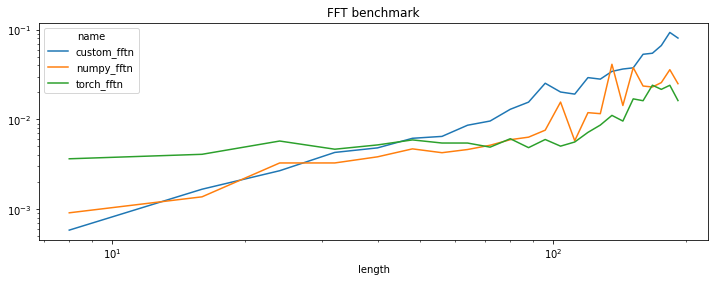

In [10]:
piv.plot(logy=True, logx=True, title="FFT benchmark", figsize=(12, 4));

In [11]:
df = benchmark({'numpy_fftn': numpy_fftn, 'custom_fftn': custom_fftn, 'torch_fftn': torch_fftn},
              power2=True)
piv = df.pivot("length", "name", "average")
piv

100%|██████████| 10/10 [00:13<00:00,  1.33s/it]


name,custom_fftn,numpy_fftn,torch_fftn
length,,,
2,0.000434,0.001167,0.023980
4,0.001117,0.001671,0.022530
8,0.001428,0.002077,0.022102
16,0.004654,0.002874,0.019792
32,0.003172,0.002689,0.017474
64,0.006966,0.004612,0.018116
128,0.030904,0.011608,0.023369
256,0.123821,0.025853,0.023532
512,0.476802,0.043352,0.033228


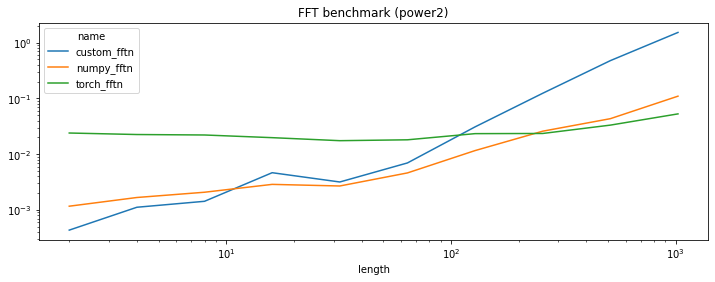

In [12]:
piv.plot(logy=True, logx=True, title="FFT benchmark (power2)", figsize=(12, 4));

## Profiling

In [13]:
from pyquickhelper.pycode.profiling import profile2graph, profile

shape = [512, 128]
fft_length = [128]
axes = [1]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * 1j

def f():
    for i in range(100):
        custom_fftn(rnd, 'FFT', fft_length, axes)

stat, text = profile(f)
gr = profile2graph(stat)
print(gr[0].to_text(fct_width=40))

f                                        --    1    1 -- 0.01752 0.54515 -- <ipython-input-81-3ee1763130c2>:8:f (f)
    custom_fftn                          --  100  100 -- 0.00234 0.52763 -- <ipython-input-7-85a4c9f552d3>:57:custom_fftn (custom_fftn)
        custom_fft                       --  100  100 -- 0.19936 0.52516 -- <ipython-input-7-85a4c9f552d3>:20:custom_fft (custom_fft)
            _dft_cst                     --  100  100 -- 0.31917 0.32366 -- <ipython-input-61-afe90fb073f9>:4:_dft_cst (_dft_cst)
                _arange                  --  200  200 -- 0.00088 0.00449 -- <ipython-input-61-afe90fb073f9>:5:_arange (_arange)
                    <method '...objects> --  200  200 -- 0.00128 0.00128 -- ~:0:<method 'astype' of 'numpy.ndarray' objects> (<method 'astype' of 'numpy.ndarray' objects>)
                    <method '...objects> --  200  200 -- 0.00064 0.00064 -- ~:0:<method 'reshape' of 'numpy.ndarray' objects> (<method 'reshape' of 'numpy.ndarray' objects>)
          

We can see that function `_dft_cst` is the bottle neck and more precisely the exponential. We need to use the symmetries of the matrix it builds.

## Faster _dft_cst

The function builds the matrix $M_{nk} = \left( \exp\left(\frac{-2i\pi nk}{K}\right) \right)_{nk}$ where $1 \leqslant n \leqslant N$ and $1 \leqslant k \leqslant K$. So it computes powers of the unity roots.

$$
\exp\left(\frac{-2i\pi nk}{K}\right) = \exp\left(\frac{-2i\pi k}{K}\right)^n = \exp\left(\frac{-2i\pi}{K}\right)^{nk}
$$

We use that expression to reduce the number of exponentiels to compute.

In [14]:
import numpy
from numpy.testing import assert_almost_equal

def _dft_cst(N, fft_length, dtype=numpy.float32):
    def _arange(dim, dtype, resh):
        return numpy.arange(dim).astype(dtype).reshape(resh)

    n = _arange(N, dtype, (-1, 1))
    k = _arange(fft_length, dtype, (1, -1))
    M = (-2j * numpy.pi * k / fft_length) * n
    numpy.exp(M, out=M)
    return M


M = _dft_cst(3, 4, numpy.float32)
M.shape, M.dtype

((3, 4), dtype('complex64'))

In [15]:
M = _dft_cst(4, 3, numpy.float64)
M.shape, M.dtype

((4, 3), dtype('complex128'))

In [16]:
M

array([[ 1. +0.00000000e+00j,  1. +0.00000000e+00j,  1. +0.00000000e+00j],
       [ 1. +0.00000000e+00j, -0.5-8.66025404e-01j, -0.5+8.66025404e-01j],
       [ 1. +0.00000000e+00j, -0.5+8.66025404e-01j, -0.5-8.66025404e-01j],
       [ 1. +0.00000000e+00j,  1. +2.44929360e-16j,  1. +4.89858720e-16j]])

In [17]:
def _dft_cst_power(N, fft_length, dtype=numpy.float32):
    if dtype == numpy.float32:
        ctype = numpy.complex64
    else:
        ctype = numpy.complex128
    M = numpy.empty((N, fft_length), dtype=ctype)
    M[0, :] = 1
    M[1, 0] = 1
    root = numpy.exp(numpy.pi / fft_length * (-2j))
    current = root
    M[1, 1] = root
    for i in range(2, M.shape[1]):
        current *= root
        M[1, i] = current
    for i in range(2, M.shape[0]):
        numpy.multiply(M[i-1, :], M[1, :], out=M[i, :])
    return M

M_pow = _dft_cst_power(4, 3, numpy.float64)
M_pow

array([[ 1. +0.00000000e+00j,  1. +0.00000000e+00j,  1. +0.00000000e+00j],
       [ 1. +0.00000000e+00j, -0.5-8.66025404e-01j, -0.5+8.66025404e-01j],
       [ 1. +0.00000000e+00j, -0.5+8.66025404e-01j, -0.5-8.66025404e-01j],
       [ 1. +0.00000000e+00j,  1. +6.10622664e-16j,  1. +1.22124533e-15j]])

In [18]:
assert_almost_equal(M, M_pow)

In [19]:
dims = (10, 15)
assert_almost_equal(_dft_cst(*dims, dtype=numpy.float32), 
                    _dft_cst_power(*dims, dtype=numpy.float32),
                    decimal=5)

## Benchmark again

In [20]:
def custom_fftn_power(*args, **kwargs):
    return custom_fftn(*args, dft_fct=_dft_cst_power, **kwargs)


%timeit -r 1 -n 1 test_fct(numpy_fftn, custom_fftn_power, decimal=4)

1.46 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [21]:
df = benchmark({
    'numpy_fftn': numpy_fftn, 'torch_fftn': torch_fftn, 'custom_fftn': custom_fftn, 
    'custom_fftn_power': custom_fftn_power})
piv = df.pivot("length", "name", "average")
piv[:5]

100%|██████████| 24/24 [00:07<00:00,  3.19it/s]


name,custom_fftn,custom_fftn_power,numpy_fftn,torch_fftn
length,,,,
8,0.000991,0.000837,0.001177,0.007033
16,0.002758,0.002591,0.002069,0.006228
24,0.003087,0.002816,0.002499,0.005564
32,0.003767,0.003068,0.003306,0.005985
40,0.004710,0.003975,0.004044,0.005733


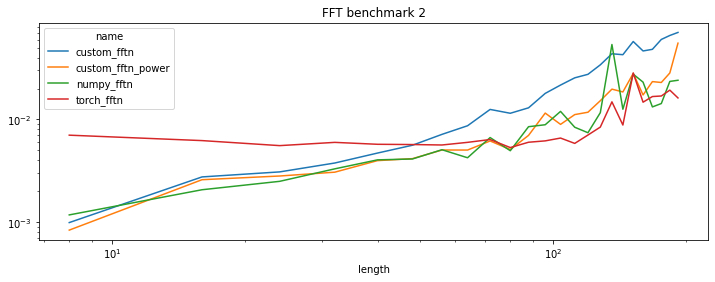

In [22]:
piv.plot(logy=True, logx=True, title="FFT benchmark 2", figsize=(12, 4));

In [23]:
from pyquickhelper.pycode.profiling import profile2graph, profile

shape = [512, 128]
fft_length = [128]
axes = [1]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * 1j

def f():
    for i in range(100):
        custom_fftn_power(rnd, 'FFT', fft_length, axes)

stat, text = profile(f)
gr = profile2graph(stat)
print(gr[0].to_text(fct_width=40))

f                                        --    1    1 -- 0.02624 0.57688 -- <ipython-input-92-112d00957d81>:8:f (f)
    custom_fftn_power                    --  100  100 -- 0.00094 0.55064 -- <ipython-input-88-b403af8c0b43>:1:custom_fftn_power (custom_fftn_power)
        custom_fftn                      --  100  100 -- 0.00609 0.54970 -- <ipython-input-7-85a4c9f552d3>:57:custom_fftn (custom_fftn)
            custom_fft                   --  100  100 -- 0.46378 0.54342 -- <ipython-input-7-85a4c9f552d3>:20:custom_fft (custom_fft)
                _dft_cst_power           --  100  100 -- 0.07599 0.07726 -- <ipython-input-85-8502f1ddbe1f>:1:_dft_cst_power (_dft_cst_power)
                    <built-in...y.empty> --  100  100 -- 0.00126 0.00126 -- ~:0:<built-in method numpy.empty> (<built-in method numpy.empty>)
                <built-in m...ltins.len> --  100  100 -- 0.00008 0.00008 -- ~:0:<built-in method builtins.len> (<built-in method builtins.len>) +++
                <method 'to...' ob

## Cooley–Tukey FFT algorithm

See [Cooley–Tukey FFT algorithm](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm).

The FFT matrix is defined by the matrix computation $F_{ak} = X_{an} M_{nk}$, then one coefficient is ($1 \leqslant n, k \leqslant K$):

$$
F_{ak} = \sum_n X_{an} M_{nk} = \sum_n X_{an} \exp\left(\frac{-2i\pi}{K}\right)^{nk}
$$

Let's assume K is even, then $\exp\left(\frac{-2i\pi k}{K}\right) = -\exp\left(\frac{-2i\pi \left(k + \frac{K}{2}\right)}{K}\right)$.

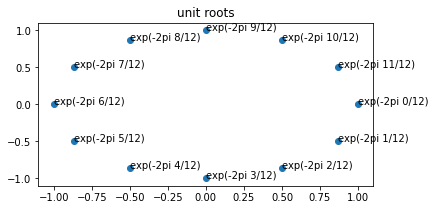

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
a = numpy.arange(0, 12) * (-2 * numpy.pi / 12)
X = numpy.vstack([numpy.cos(a), numpy.sin(a)]).T
ax.plot(X[:, 0], X[:, 1], 'o');
for i in range(0, 12):
    ax.text(X[i, 0], X[i, 1], "exp(-2pi %d/12)" % i)
ax.set_title('unit roots');

Then:

$$
\begin{array}{rcl}
F_{a,k + \frac{K}{2}} &=& \sum_{n=1}^{N} X_{an} \exp\left(\frac{-2i\pi}{K}\right)^{n\left(k + \frac{K}{2}\right)} \\
&=&\sum_{n=1}^{N} X_{an} (-1)^n \exp\left(\frac{-2i\pi}{K}\right)^{nk} \\
&=&\sum_{m=1}^{\frac{N}{2}} X_{a,2m} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} - \sum_{m=1}^{\frac{N}{2}} X_{a,2m-1} \exp\left(\frac{-2i\pi}{K}\right)^{(2m-1)k} \\
&=&\sum_{m=1}^{\frac{N}{2}} X_{a,2m} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} - \sum_{m=1}^{\frac{N}{2}} X_{a,2m-1} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} \exp\left(\frac{-2i\pi}{K}\right)^{-k}
\end{array}
$$

Then:

$$
\begin{array}{rcl}
F_{a,k} + F_{a,k+\frac{K}{2}} &=& 2\sum_{m=1}^{\frac{N}{2}} X_{a,2m}  \exp\left(\frac{-2i\pi}{K}\right)^{2mk}
= 2\sum_{m=1}^{\frac{N}{2}} X_{a,2m}  \exp\left(\frac{-2i\pi}{\frac{K}{2}}\right)^{mk}
\end{array}
$$

Finally:

$$
\begin{array}{rcl}
F_{a,k} &=& \sum_{m=1}^{\frac{N}{2}} X_{a,2m} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} + \sum_{m=1}^{\frac{N}{2}} X_{a,2m-1} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} \exp\left(\frac{-2i\pi}{K}\right)^{-k} \\
F_{a,k + \frac{K}{2}} &=&\sum_{m=1}^{\frac{N}{2}} X_{a,2m} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} - \sum_{m=1}^{\frac{N}{2}} X_{a,2m-1} \exp\left(\frac{-2i\pi}{K}\right)^{2mk} \exp\left(\frac{-2i\pi}{K}\right)^{-k}
\end{array}
$$

Now, what happen when *K* is odd, fallback to the original computation.

$$
F_{ak} = \sum_n X_{an} M_{nk} = \sum_n X_{an} \exp\left(\frac{-2i\pi}{K}\right)^{nk}
$$

In [25]:
import functools


def cooley_fft_2p(x, fft_length):
    cst = _dft_cst_power(x.shape[-1], fft_length, x.dtype)
    return numpy.matmul(x, cst)


@functools.cache
def _build_fact(p2_2, fft_length, dtype):
    first = numpy.exp(-2j * numpy.pi / fft_length)
    fact = numpy.ones(p2_2, dtype=dtype)
    for k in range(1, p2_2):
        fact[k] = fact[k-1] * first
    return fact.reshape((1, -1))


def build_fact(p2_2, fft_length, dtype):
    return _build_fact(p2_2, fft_length, dtype)


def cooley_fft_recursive(x, fft_length):
    if len(x.shape) != 2:
        raise RuntimeError(
            "Unexpected x.shape=%r." % (x.shape, ))
    dtype = numpy.complex128 if x.dtype == numpy.float64 else numpy.complex64
    if fft_length == 1:
        return x[:, :1].astype(dtype)

    if fft_length % 2 == 0:
        def split(x):
            even = x[:, ::2]
            odd = x[:, 1::2]
            return even, odd

        def tmp1(even, odd, fft_length):
            p2_2 = fft_length // 2
            fft_even = cooley_fft_recursive(even, p2_2)
            fft_odd = cooley_fft_recursive(odd, p2_2)
            return fft_even, fft_odd, p2_2

        def tmp2(x, fft_even, fft_odd, p2_2):
            fact = build_fact(p2_2, fft_length, fft_even.dtype)

            fact_odd = fft_odd * fact
            return numpy.hstack([fft_even + fact_odd, fft_even - fact_odd])

            # inplace
            # result = numpy.empty((x.shape[0], fft_length), dtype=fft_even.dtype)
            # numpy.multiply(fft_odd, fact, out=result[:, :p2_2])
            # numpy.subtract(fft_even, result[:, :p2_2], out=result[:, p2_2:])
            # numpy.add(fft_even, result[:, :p2_2], out=result[:, :p2_2])
            # return result
    
        even, odd = split(x)
        fft_even, fft_odd, p2_2 = tmp1(even, odd, fft_length)
        result = tmp2(x, fft_even, fft_odd, p2_2)
    else:
        result = cooley_fft_2p(x, fft_length)
        
    return result



def cooley_fft(x, fft_length):
    return cooley_fft_recursive(x, fft_length)


def custom_fft_cooley(x, fft_type, length, axis):
    # https://github.com/numpy/numpy/blob/4adc87dff15a247e417d50f10cc4def8e1c17a03/numpy/fft/_pocketfft.py#L56
    if fft_type == 'FFT':
        if x.shape[axis] > length:
            # fft_length > shape on the same axis
            # the matrix is shortened
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            new_x = x[tuple(slices)]
        elif x.shape[axis] == length:
            new_x = x
        else:
            # other, the matrix is completed with zeros
            shape = list(x.shape)
            shape[axis] = length
            slices = [slice(None)] * len(x.shape)
            slices[axis] = slice(0, length)
            zeros = numpy.zeros(tuple(shape), dtype=x.dtype)
            index = [slice(0, i) for i in x.shape]
            zeros[tuple(index)] = x
            new_x = zeros

        if axis == len(new_x.shape) - 1:
            if len(new_x.shape) != 2:
                xt = new_x.reshape((-1, new_x.shape[-1]))
            else:
                xt = new_x
            res = cooley_fft(xt, length)
            if len(new_x.shape) != 2:
                res = res.reshape(new_x.shape[:-1] + (-1, ))
        else:
            perm = numpy.arange(len(x.shape)).tolist()        
            perm[axis], perm[-1] = perm[-1], perm[axis]            
            rest = new_x.transpose(perm)
            shape = rest.shape[:-1]
            rest = rest.reshape((-1, rest.shape[-1]))
            res = cooley_fft(rest, length)
            res = res.reshape(shape + (-1, )).transpose(perm)
            perm[axis], perm[0] = perm[0], perm[axis]
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)


def custom_fftn_cooley(x, fft_type, fft_length, axes):
    if len(axes) != len(fft_length):
        raise ValueError("Length mismatch axes=%r, fft_length=%r." % (
           axes, fft_length))
    if fft_type == 'FFT':
        res = x
        for i in range(len(fft_length) - 1, -1, -1):
            length = fft_length[i]
            axis = axes[i]
            res = custom_fft_cooley(res, fft_type, length, axis)
        return res
    raise ValueError("Unexpected value for fft_type=%r." % fft_type)
    

shape = (4, )
fft_length = [3,]
axes = [0]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * 1j
assert_almost_equal(custom_fftn_cooley(rnd, 'FFT', fft_length, axes),
                    numpy_fftn(rnd, 'FFT', fft_length, axes),
                    decimal=5)
%timeit -n 1 -r 1 test_fct(numpy_fftn, custom_fftn_cooley)

1.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [26]:
df = benchmark({
    'numpy_fftn': numpy_fftn, 'torch_fftn': torch_fftn,
    'custom_fftn_power': custom_fftn_power, 'custom_fftn_cooley': custom_fftn_cooley})
piv = df.pivot("length", "name", "average")
piv[:5]

100%|██████████| 24/24 [00:10<00:00,  2.35it/s]


name,custom_fftn_cooley,custom_fftn_power,numpy_fftn,torch_fftn
length,,,,
8,0.002873,0.000685,0.001482,0.005463
16,0.007197,0.002121,0.001922,0.005063
24,0.009443,0.002903,0.002739,0.005169
32,0.012783,0.002556,0.002003,0.004076
40,0.014142,0.003916,0.003937,0.005118


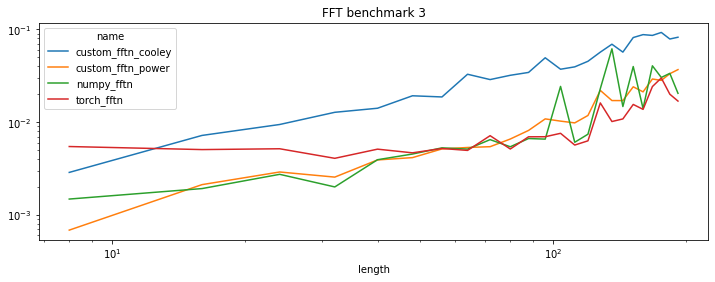

In [27]:
piv.plot(logy=True, logx=True, title="FFT benchmark 3", figsize=(12, 4));

In [28]:
df = benchmark({
    'numpy_fftn': numpy_fftn, 'torch_fftn': torch_fftn,
    'custom_fftn_power': custom_fftn_power, 'custom_fftn_cooley': custom_fftn_cooley},
    power2=True)
piv = df.pivot("length", "name", "average")
piv[:5]

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


name,custom_fftn_cooley,custom_fftn_power,numpy_fftn,torch_fftn
length,,,,
2,0.000575,0.000471,0.000722,0.019371
4,0.001153,0.000328,0.001130,0.018366
8,0.003678,0.000624,0.001779,0.019295
16,0.006843,0.002255,0.002192,0.020169
32,0.015574,0.003045,0.002736,0.017193


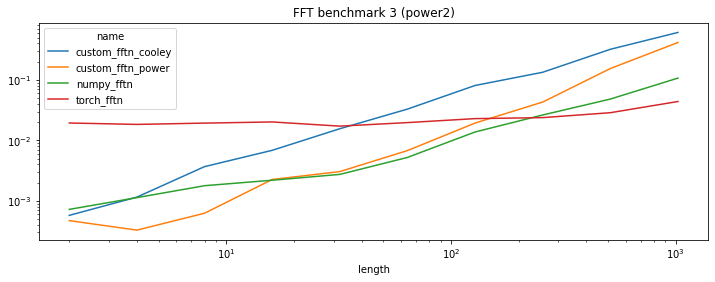

In [29]:
piv.plot(logy=True, logx=True, title="FFT benchmark 3 (power2)", figsize=(12, 4));

In [30]:
from pyquickhelper.pycode.profiling import profile2graph, profile

shape = [512, 256]
fft_length = [256]
axes = [1]
rnd = numpy.random.randn(*shape) + numpy.random.randn(*shape) * 1j

def f():
    for i in range(100):
        custom_fftn_cooley(rnd, 'FFT', fft_length, axes)

stat, text = profile(f)
gr = profile2graph(stat)
print(gr[0].to_text(fct_width=40))

cooley_fft_recursive                     --    100  51100 -- 0.24497 2.68339 -- <ipython-input-139-b9d3f22689f8>:22:cooley_fft_recursive (cooley_fft_recursive)
    split                                --  25500  25500 -- 0.06264 0.06264 -- <ipython-input-139-b9d3f22689f8>:31:split (split)
    tmp1                                 --    100  25500 -- 0.09438 2.54540 -- <ipython-input-139-b9d3f22689f8>:36:tmp1 (tmp1)
        cooley_fft_recursive             --  51000    200 -- 0.24336 2.54421 -- <ipython-input-139-b9d3f22689f8>:22:cooley_fft_recursive (cooley_fft_recursive) +++
    tmp2                                 --  25500  25500 -- 0.95948 2.04473 -- <ipython-input-139-b9d3f22689f8>:42:tmp2 (tmp2)
        hstack                           --  25500  25500 -- 0.04799 1.05776 -- <__array_function__ internals>:177:hstack (hstack)
            _vhstack_dispatcher          --  25500  25500 -- 0.02712 0.07002 -- C:/Python395_x64/lib/site-packages/numpy/core/shape_base.py:218:_vhstack_dispat